# <center>The Battle of Neighborhoods - Bangalore</center>

## <center>Applied Data Science Capstone by IBM on Coursera</center>

This project deals with discussing the neighborhoods of **Bangalore, India**. This project would specifically help Business people planning to start **Restaurants, Hotels, etc.** in Bangalore, India.

The **Foursquare API** is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analyzing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the **k-means clustering algorithm** is used to achieve the task. The optimal number of clusters can be obtained using **silhouette score**. **Folium visualization library** can be used to visualize the clusters superimposed on the map of Bangalore city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

#### Import the required libraries

In [1]:
!pip install beautifulsoup4
!pip install geopy

import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


#### Import the Bangalore city data from CSV file

In [2]:
data = pd.read_csv (r'blr_neighborhoods.csv')   
bang_data = pd.DataFrame(data, columns= ['Location','Latitude','Longitude'])
print (bang_data)

                         Location   Latitude   Longitude
0                           Agram  45.813177   15.977048
1                    Amruthahalli  13.066513   77.596624
2                           Attur  11.663711   78.533551
3                       Banaswadi  13.014162   77.651854
4                       Bellandur  58.235358   26.683116
5                   Bhattarahalli  13.025800   77.714279
6                      Bidrahalli  14.577426   74.928560
7                 Byatarayanapura  13.062074   77.596392
8                     Devanagundi  12.973613   77.839402
9                      Devasandra  12.757227   77.647280
10                     Doddagubbi  14.452076   75.510799
11                  Doddanekkundi  12.975720   77.694042
12                         Domlur  12.962467   77.638196
13                           EPIP  12.977673   77.722200
14                    Fraser Town  42.245363  -74.964607
15                         Gunjur  13.176020  -16.759896
16                      HighCou

In [3]:
bang_data.head()


,Location,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,58.235358,26.683116


In [4]:
print(bang_data.shape)

(352, 3)


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Bangalore. The latitude and longitude of Bangalore can be obtained using the Geolocator library.

In [5]:
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Bangalore are 12.9791198, 77.5912997.


In [6]:
bang_map = folium.Map(location=[latitude, longitude], zoom_start=12)    
bang_map

#### Bangalore Map with the neighborhoods superimposed on top:

In [7]:
# add neighborhood markers to map
for lat, lng, location in zip(bang_data['Latitude'], bang_data['Longitude'], bang_data['Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bang_map)  

bang_map

#### Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = '1PTZ4GBORBZEXD10IHPQZF1N3RB11Y2MUKNN0EBKJ31F5W0Q' # your Foursquare ID
CLIENT_SECRET = 'A21B5CRBQMM5B0TZ0LNZT4IBTXSR1LZEMCYTCKTGVC2HBHVU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Explore neighborhoods in Bangalore

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
CLIENT_ID = '1PTZ4GBORBZEXD10IHPQZF1N3RB11Y2MUKNN0EBKJ31F5W0Q' # your Foursquare ID
CLIENT_SECRET = 'A21B5CRBQMM5B0TZ0LNZT4IBTXSR1LZEMCYTCKTGVC2HBHVU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

bang_venues = getNearbyVenues(names = bang_data['Location'],
                                 latitudes = bang_data['Latitude'],
                                 longitudes = bang_data['Longitude']
                                 )

print(bang_venues.shape)
bang_venues.head()

(776, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant
3,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market
4,Agram,45.813177,15.977048,Cremme Zagreb,45.814987,15.976296,Dessert Shop


In [11]:
bang_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Achitnagar,1,1,1,1,1,1
Adugodi,5,5,5,5,5,5
Agram,99,99,99,99,99,99
Akkur,28,28,28,28,28,28
Alahalli,1,1,1,1,1,1
Amruthahalli,3,3,3,3,3,3
Anekal,3,3,3,3,3,3
Arudi,3,3,3,3,3,3
Attibele,4,4,4,4,4,4


In [12]:
print('There are {} uniques categories.'.format(len(bang_venues['Venue Category'].unique())))

There are 179 uniques categories.


## Analysis <a name="analysis"></a>

First, lets visualize the number of venues obtained in all the neighborhoods of Bangalore.

<AxesSubplot:xlabel='Neighborhood'>

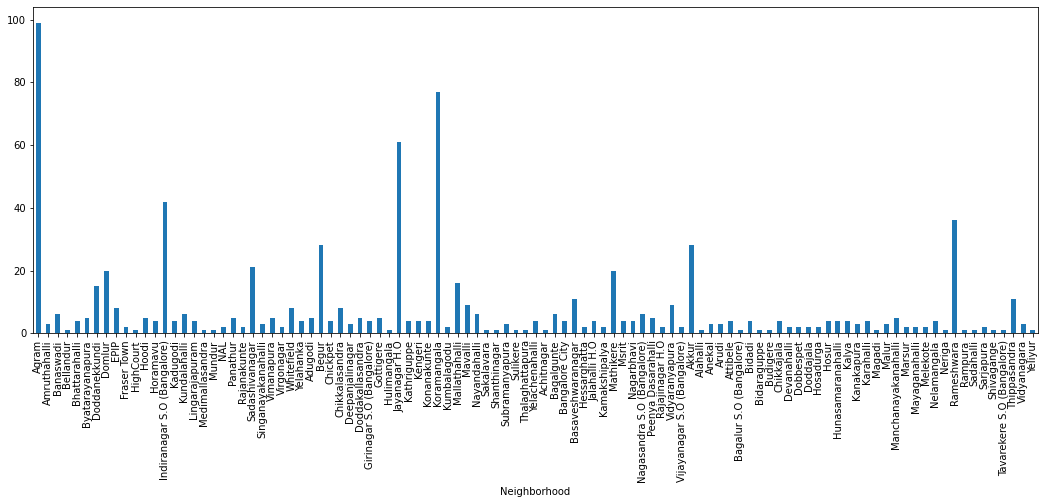

In [13]:
df = bang_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 15 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 15 or more than 15 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

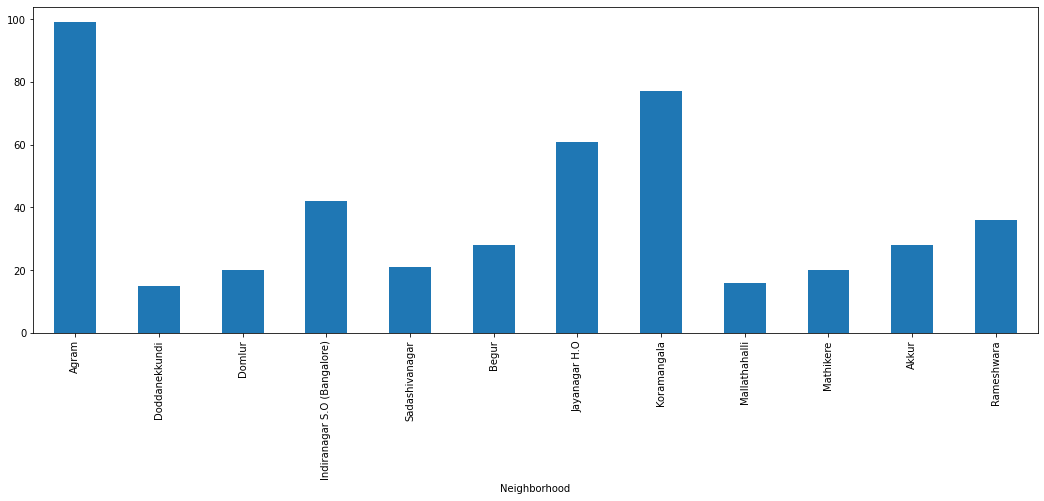

In [14]:
df = df[df >= 15]
df.plot.bar(figsize=(18,6))

In [15]:
bang_venues_top = bang_venues[bang_venues['Neighborhood'].isin(df.index.tolist())]
bang_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant
3,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market
4,Agram,45.813177,15.977048,Cremme Zagreb,45.814987,15.976296,Dessert Shop


#### One hot encoding

In [16]:
bang_onehot = pd.get_dummies(bang_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bang_onehot['Neighborhood'] = bang_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = bang_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
bang_onehot = bang_onehot.reindex(columns = fixed_columns)

print(bang_onehot.shape)
bang_onehot.head()

(463, 122)


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Optical Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plaza,Pub,Rajasthani Restaurant,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Tunnel,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
bang_grouped = bang_onehot.groupby('Neighborhood').mean().reset_index()
print(bang_grouped.shape)
bang_grouped.head()

(12, 122)


,Neighborhood,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Optical Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Plaza,Pub,Rajasthani Restaurant,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Tunnel,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Agram,0.0,0.0,0.0,0.010101,0.010101,0.010101,0.000000,0.0,0.090909,0.0,0.050505,0.0,0.0,0.0,0.010101,0.0,0.020202,0.0,0.040404,0.0,0.000000,0.0,0.000000,0.000000,0.010101,0.020202,0.000000,0.010101,0.0,0.010101,0.00,0.010101,0.040404,0.0,0.000000,0.0,0.030303,0.0,0.010101,0.010101,0.010101,0.00,0.0,0.000000,0.000000,0.0,0.0,0.010101,0.0,0.0,0.010101,0.0,0.050505,0.010101,0.010101,0.020202,0.010101,0.010101,0.0,0.020202,0.010101,0.0,0.0,0.0,0.000000,0.010101,0.010101,0.00,0.0,0.060606,0.0,0.0,0.000000,0.0,0.0,0.010101,0.000000,0.000000,0.000000,0.020202,0.0,0.000000,0.0,0.020202,0.010101,0.030303,0.0,0.000000,0.000000,0.010101,0.010101,0.020202,0.070707,0.020202,0.00,0.020202,0.010101,0.000000,0.010101,0.010101,0.0,0.0,0.000000,0.0,0.0,0.000000,0.010101,0.000000,0.0,0.0,0.0,0.030303,0.000000,0.010101,0.010101,0.0,0.0,0.00,0.020202,0.0,0.0
1,Akkur,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.071429,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.071429,0.0,0.000000,0.000000,0.000000,0.0,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.071429,0.000000,0.000000,0.0,0.0,0.071429,0.0,0.0,0.000000,0.000000,0.214286,0.0,0.0,0.0,0.000000,0.071429,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0
2,Begur,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.071429,0.0,0.214286,0.0,0.000000,0.0,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.071429,0.000000,0.0,0.0,0.0,0.071429,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.071429,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.071429,0.0

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bang_grouped['Neighborhood']

for ind in np.arange(bang_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bang_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,Bar,Plaza,Mediterranean Restaurant,Bistro,Historic Site,Café,Dessert Shop,Theater,Eastern European Restaurant,Pedestrian Plaza
1,Akkur,Supermarket,Pharmacy,Bar,Pet Store,Optical Shop,Discount Store,Clothing Store,Chinese Restaurant,Sandwich Place,Furniture / Home Store
2,Begur,Café,Supermarket,Mini Golf,Pizza Place,Burger Joint,Climbing Gym,Bar,Comedy Club,Korean Restaurant,Park
3,Doddanekkundi,Indian Restaurant,Hotel,Multiplex,Mediterranean Restaurant,Coffee Shop,Restaurant,Movie Theater,Motorcycle Shop,Fast Food Restaurant,Sports Bar
4,Domlur,Indian Restaurant,Café,Chinese Restaurant,Deli / Bodega,Sports Bar,Liquor Store,Pizza Place,Restaurant,Pub,BBQ Joint


#### Cluster Neighborhoods

Here k-Nearest Neighborhoods clustering technique is used. Lets use the **silhouette_score** to obtain the best value for the number of clusters.

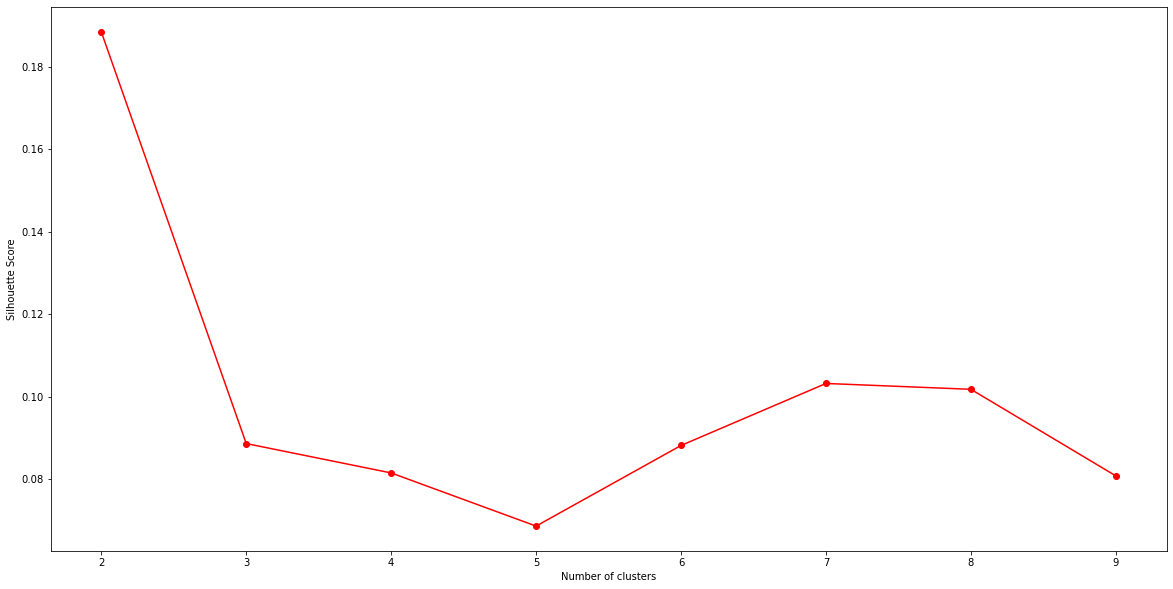

In [20]:
bang_grouped_clustering = bang_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(bang_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(bang_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [21]:
# select best number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bang_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 5, 1, 6, 0, 2, 0, 0, 4, 3], dtype=int32)

In [22]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bang_merged = bang_venues_top[bang_venues_top.columns[0:3]].drop_duplicates()
bang_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bang_merged = bang_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bang_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,45.813177,15.977048,2,Bar,Plaza,Mediterranean Restaurant,Bistro,Historic Site,Café,Dessert Shop,Theater,Eastern European Restaurant,Pedestrian Plaza
1,Doddanekkundi,12.975720,77.694042,6,Indian Restaurant,Hotel,Multiplex,Mediterranean Restaurant,Coffee Shop,Restaurant,Movie Theater,Motorcycle Shop,Fast Food Restaurant,Sports Bar
2,Domlur,12.962467,77.638196,0,Indian Restaurant,Café,Chinese Restaurant,Deli / Bodega,Sports Bar,Liquor Store,Pizza Place,Restaurant,Pub,BBQ Joint
3,Indiranagar S.O (Bangalore),12.973291,77.640467,2,Lounge,Pub,Cocktail Bar,Cupcake Shop,Indian Restaurant,Italian Restaurant,Restaurant,Café,Kids Store,Music Venue
4,Sadashivanagar,13.007708,77.579589,2,Indian Restaurant,Spa,Coffee Shop,Department Store,Ice Cream Shop,Dessert Shop,Plaza,Electronics Store,Chinese Restaurant,Seafood Restaurant


In [23]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

## Results <a name="results"></a>

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

In [24]:
bang_merged.loc[bang_merged['Cluster Labels'] == 0, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Domlur,Indian Restaurant,Café,Chinese Restaurant,Deli / Bodega,Sports Bar,Liquor Store,Pizza Place,Restaurant,Pub,BBQ Joint
6,Jayanagar H.O,Indian Restaurant,Café,Chinese Restaurant,Juice Bar,Fast Food Restaurant,Restaurant,Sandwich Place,Women's Store,Gym,Gastropub
7,Koramangala,Indian Restaurant,Café,Coffee Shop,Pub,Italian Restaurant,Juice Bar,Seafood Restaurant,Ice Cream Shop,Chinese Restaurant,Kerala Restaurant


In [25]:
cluster1 = bang_merged.loc[bang_merged['Cluster Labels'] == 0, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Indian Restaurant     3
Café                  3
Chinese Restaurant    3
Juice Bar             2
Restaurant            2
Pub                   2
Italian Restaurant    1
Gym                   1
Seafood Restaurant    1
Ice Cream Shop        1
dtype: int64


In [26]:
bang_merged.loc[bang_merged['Cluster Labels'] == 1, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Begur,Café,Supermarket,Mini Golf,Pizza Place,Burger Joint,Climbing Gym,Bar,Comedy Club,Korean Restaurant,Park


In [27]:
cluster2 = bang_merged.loc[bang_merged['Cluster Labels'] == 1, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Comedy Club          1
Korean Restaurant    1
Café                 1
Park                 1
Supermarket          1
Mini Golf            1
Bar                  1
Burger Joint         1
Pizza Place          1
Climbing Gym         1
dtype: int64


In [28]:
bang_merged.loc[bang_merged['Cluster Labels'] == 2, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,Bar,Plaza,Mediterranean Restaurant,Bistro,Historic Site,Café,Dessert Shop,Theater,Eastern European Restaurant,Pedestrian Plaza
3,Indiranagar S.O (Bangalore),Lounge,Pub,Cocktail Bar,Cupcake Shop,Indian Restaurant,Italian Restaurant,Restaurant,Café,Kids Store,Music Venue
4,Sadashivanagar,Indian Restaurant,Spa,Coffee Shop,Department Store,Ice Cream Shop,Dessert Shop,Plaza,Electronics Store,Chinese Restaurant,Seafood Restaurant
11,Rameshwara,Clothing Store,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Donut Shop,Electronics Store,Coffee Shop,American Restaurant,Miscellaneous Shop,Sandwich Place


In [29]:
cluster3 = bang_merged.loc[bang_merged['Cluster Labels'] == 2, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Indian Restaurant      3
Electronics Store      2
Ice Cream Shop         2
Dessert Shop           2
Plaza                  2
Café                   2
Coffee Shop            2
Historic Site          1
American Restaurant    1
Music Venue            1
dtype: int64


In [30]:
bang_merged.loc[bang_merged['Cluster Labels'] == 3, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Mathikere,American Restaurant,Bakery,Café,Bus Station,Burger Joint,Gym,Market,Diner,Ice Cream Shop,Indian Restaurant


In [31]:
cluster4 = bang_merged.loc[bang_merged['Cluster Labels'] == 3, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Market                 1
Diner                  1
Bus Station            1
Café                   1
Ice Cream Shop         1
Bakery                 1
Indian Restaurant      1
American Restaurant    1
Burger Joint           1
Gym                    1
dtype: int64


In [32]:
bang_merged.loc[bang_merged['Cluster Labels'] == 4, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Mallathahalli,Café,Indian Restaurant,Market,Breakfast Spot,Gym,South Indian Restaurant,Andhra Restaurant,Eastern European Restaurant,Electronics Store,Escape Room


In [33]:
cluster5 = bang_merged.loc[bang_merged['Cluster Labels'] == 4, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Market                         1
Andhra Restaurant              1
Electronics Store              1
Café                           1
South Indian Restaurant        1
Breakfast Spot                 1
Gym                            1
Eastern European Restaurant    1
Escape Room                    1
Indian Restaurant              1
dtype: int64


In [34]:
bang_merged.loc[bang_merged['Cluster Labels'] == 5, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Akkur,Supermarket,Pharmacy,Bar,Pet Store,Optical Shop,Discount Store,Clothing Store,Chinese Restaurant,Sandwich Place,Furniture / Home Store


In [35]:
cluster6 = bang_merged.loc[bang_merged['Cluster Labels'] == 5, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Clothing Store            1
Discount Store            1
Furniture / Home Store    1
Chinese Restaurant        1
Optical Shop              1
Supermarket               1
Pet Store                 1
Bar                       1
Pharmacy                  1
Sandwich Place            1
dtype: int64


In [36]:
bang_merged.loc[bang_merged['Cluster Labels'] == 6, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Doddanekkundi,Indian Restaurant,Hotel,Multiplex,Mediterranean Restaurant,Coffee Shop,Restaurant,Movie Theater,Motorcycle Shop,Fast Food Restaurant,Sports Bar


In [37]:
cluster7 = bang_merged.loc[bang_merged['Cluster Labels'] == 6, bang_merged.columns[[0] + 
                                                                                    list(range(4, bang_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Fast Food Restaurant        1
Motorcycle Shop             1
Mediterranean Restaurant    1
Sports Bar                  1
Movie Theater               1
Coffee Shop                 1
Multiplex                   1
Hotel                       1
Restaurant                  1
Indian Restaurant           1
dtype: int64


IndexError: list index out of range

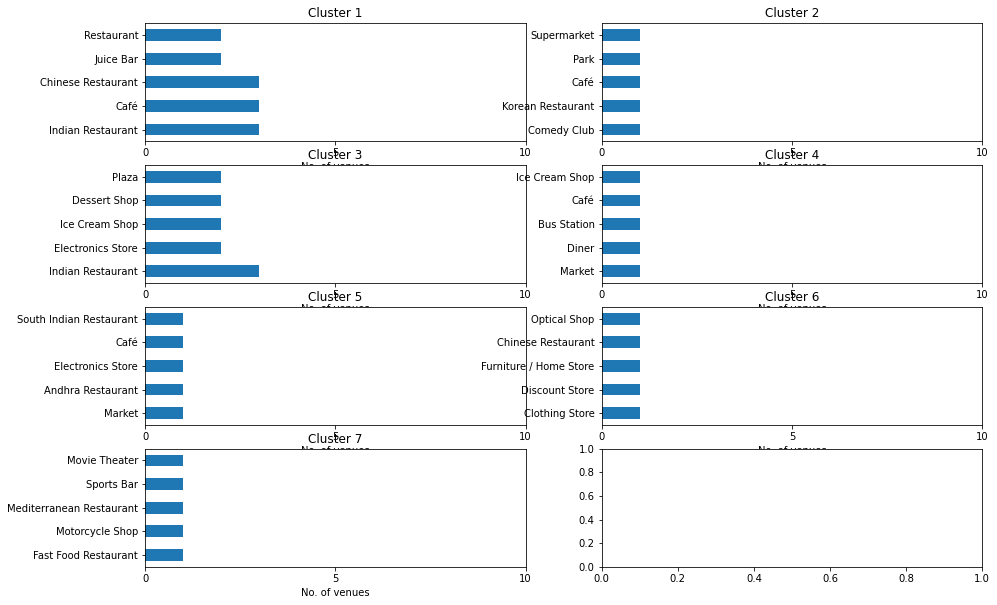

In [38]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

#### Map of Bangalore with the clusters superimposed on top

In [39]:
# create map
bang_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bang_merged['Neighborhood Latitude'], bang_merged['Neighborhood Longitude'], bang_merged['Neighborhood'], bang_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bang_clusters_map)
       
bang_clusters_map

## Conclusion <a name="conclusion"></a>

Purpose of this project was to analyze the neighborhoods of Bangalore and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 15 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster. 

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.